[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Segment Videos with Segment Anything 3 (SAM3)

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-videos-with-segment-anything-3.ipynb)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/sam3/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/sam3)

SAM 3 (Segment Anything Model 3) extends the SAM series by moving from segmenting individual objects to understanding and segmenting all instances of a concept in images and videos. It introduces Promptable Concept Segmentation (PCS), where users specify a concept through short noun phrases like “striped cat” or by providing visual exemplars. The model detects, segments, and tracks every matching object, preserving identities across frames.


## Environment setup

### Configure your API keys

To pull Segment Anything 3 weights, you need a HuggingFace Access Token with approved access to the SAM 3 checkpoints.

- Request access to the SAM 3 checkpoints on the official Hugging Face [repo](https://github.com/facebookresearch/sam3).
- Open your HuggingFace Settings page. Click Access Tokens then New Token to generate a new token.
- In Colab, go to the left pane and click on Secrets (🔑). Store your HuggingFace Access Token under the name `HF_TOKEN`.



### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Wed Nov 19 15:27:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   46C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
CUDA is available: True


### Install SAM 3 and extra dependencies

In [ ]:
!git clone https://github.com/facebookresearch/sam3.git
%cd sam3
!pip install -e ".[notebooks]"
%cd /content

In [ ]:
!pip install -q supervision jupyter_bbox_widget

In [ ]:
!pip uninstall -y cc_torch; TORCH_CUDA_ARCH_LIST="8.0 9.0"; pip install git+https://github.com/ronghanghu/cc_torch
!pip uninstall -y torch_generic_nms; TORCH_CUDA_ARCH_LIST="8.0 9.0"; pip install git+https://github.com/ronghanghu/torch_generic_nms

### Download example data

Downloads example videos. You can use these or replace them with your own videos.

In [ ]:
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/basketball-1-30fps.mp4
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/basketball-2-30fps.mp4
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/basketball-3-30fps.mp4
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/jets-1280x720-1.mp4

<font color="red">⚠️ Restart session.</font>

## Imports

In [ ]:
import cv2
import torch

import numpy as np
import supervision as sv

from pathlib import Path
from PIL import Image
from typing import Optional
from IPython.display import Video

from sam3.model_builder import build_sam3_video_predictor

In [ ]:
HOME = Path.cwd()
print("HOME:", HOME)

HOME: /content


## Promptable Concept Segmentation (PCS)

### Load SAM3 model

In [ ]:
# use all available GPUs on the machine
# DEVICES = range(torch.cuda.device_count())

# # use only a single GPU
DEVICES = [torch.cuda.current_device()]

In [ ]:
predictor = build_sam3_video_predictor(gpus_to_use=DEVICES)

INFO 2025-11-19 15:39:21,639 2958 sam3_video_predictor.py: 299: using the following GPU IDs: [0]
INFO 2025-11-19 15:39:21,641 2958 sam3_video_predictor.py: 315: 


	*** START loading model on all ranks ***


INFO 2025-11-19 15:39:21,641 2958 sam3_video_predictor.py: 317: loading model on rank=0 with world_size=1 -- this could take a while ...
INFO 2025-11-19 15:39:30,529 2958 sam3_video_base.py: 124: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2025-11-19 15:39:33,975 2958 sam3_video_predictor.py: 319: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2025-11-19 15:39:33,976 2958 sam3_video_predictor.py: 330: 


	*** DONE loading model on all ranks ***




### Process the video

SAM 3 assumee that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`. Let's start by downloading a sample video, splitting it into frames, and saving them to disk. Feel free to replace `SOURCE_VIDEO` with the path to your video file.

In [ ]:
SOURCE_VIDEO = HOME / "basketball-1-30fps.mp4"
SOURCE_FRAMES = HOME / SOURCE_VIDEO.stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

!ffmpeg -i {SOURCE_VIDEO} -q:v 2 -start_number 0 {SOURCE_FRAMES}/'%05d.jpg'

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
def load_frame(directory: str, index: int):
    """
    Loads a frame with a specific index from a directory where frames are named
    using the pattern '%05d.jpg' (e.g., 00000.jpg, 00001.jpg, 00002.jpg).

    Args:
        directory (str): Path to the directory containing image frames.
        index (int): Frame index (0-based).

    Returns:
        numpy.ndarray: Loaded frame in BGR format.

    Raises:
        FileNotFoundError: If the frame does not exist or cannot be read.
    """
    directory_path = Path(directory)
    frame_path = directory_path / f"{index:05d}.jpg"

    if not frame_path.exists():
        raise FileNotFoundError(f"Frame not found: {frame_path}")

    frame = cv2.imread(str(frame_path))
    if frame is None:
        raise FileNotFoundError(f"Failed to load frame: {frame_path}")

    return frame

### Opening video inference session


SAM 3 requires stateful inference for interactive video segmentation, so we need to initialize an inference session on this video. During initialization, it loads all the JPEG frames in the video directory and stores their features in the session state.

In [ ]:
response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=SOURCE_VIDEO.as_posix(),
    )
)
session_id = response["session_id"]

frame loading (OpenCV) [rank=0]: 100%|██████████| 238/238 [00:01<00:00, 209.35it/s]


In [ ]:
_ = predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

### Adding a text prompt

Here we use the text prompt "person" to detect all people in the video. SAM 3 will automatically identify multiple person instances and assign each a unique object ID.

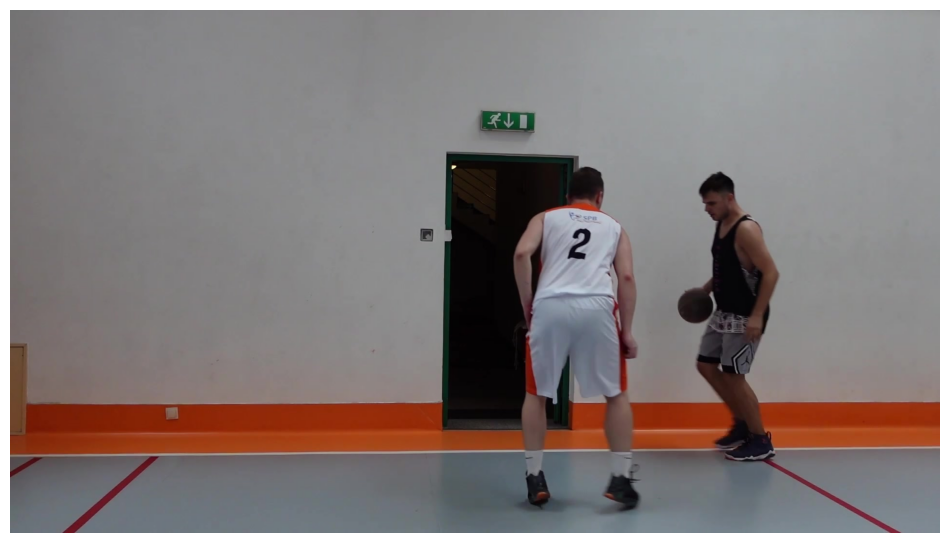

In [ ]:
frame = load_frame(SOURCE_FRAMES, 50)

sv.plot_image(frame)

In [ ]:
prompt_text_str = "ball"
frame_idx = 50
response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        text=prompt_text_str,
    )
)
result = response["outputs"]

### Visualize results

In [ ]:
def from_sam(result: dict) -> sv.Detections:
    return sv.Detections(
        xyxy=sv.mask_to_xyxy(result["out_binary_masks"]),
        mask=result["out_binary_masks"],
        confidence=result["out_probs"],
        tracker_id=result["out_obj_ids"],
    )

In [ ]:
COLOR = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

def annotate(image: np.ndarray, detections: sv.Detections) -> np.ndarray:
    h, w, _ = image.shape
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=(w, h))

    mask_annotator = sv.MaskAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        opacity=0.6
    )

    label_annotator = sv.LabelAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.INDEX,
        text_scale=text_scale,
        text_color=sv.Color.BLACK,
        text_position=sv.Position.CENTER_OF_MASS
    )

    annotated_image = image.copy()
    annotated_image = mask_annotator.annotate(annotated_image, detections)

    labels = [
        f"#{tracker_id} {confidence:.2f}"
        for tracker_id, confidence in zip(detections.tracker_id, detections.confidence)
    ]
    annotated_image = label_annotator.annotate(annotated_image, detections, labels)

    return annotated_image

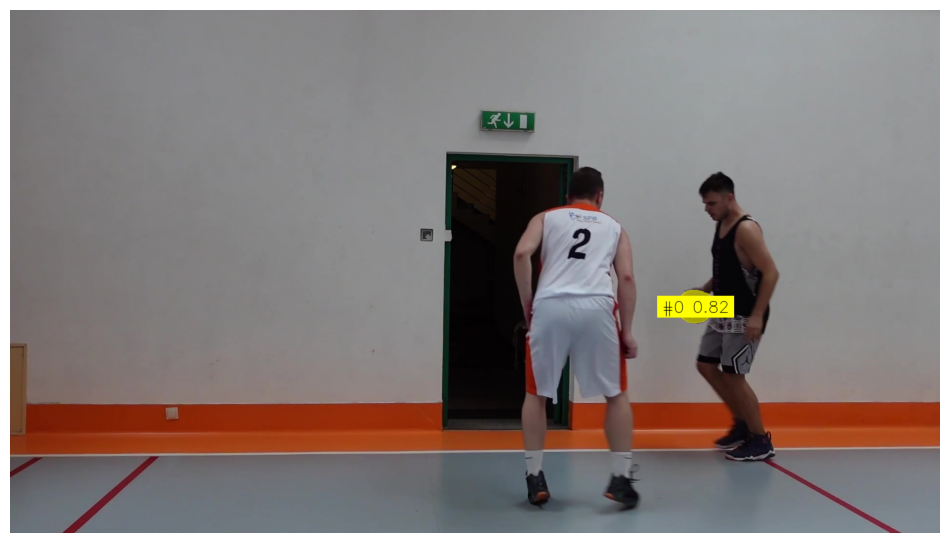

In [ ]:
detections = from_sam(result)

annotated_frame = annotate(frame, detections)

sv.plot_image(annotated_frame)

### Propagate in video

In [ ]:
def propagate_in_video(predictor, session_id):
    frame_outputs = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
        )
    ):
        frame_outputs[response["frame_index"]] = response["outputs"]

    return frame_outputs

In [ ]:
frame_outputs = propagate_in_video(predictor=predictor, session_id=session_id)

In [ ]:
TARGET_VIDEO = HOME / f"{SOURCE_VIDEO.stem}-result{SOURCE_VIDEO.suffix}"
TARGET_VIDEO_COMPRESSED = HOME / f"{TARGET_VIDEO.stem}-compressed{TARGET_VIDEO.suffix}"

def callback(frame: np.ndarray, index: int) -> np.ndarray:
    annotated_frame = frame.copy()
    output = frame_outputs[index]
    detections = from_sam(output)
    return annotate(frame, detections)

sv.process_video(
    source_path=SOURCE_VIDEO,
    target_path=TARGET_VIDEO,
    callback=callback
)

!ffmpeg -y -loglevel error -i {TARGET_VIDEO} -vcodec libx264 -crf 28 {TARGET_VIDEO_COMPRESSED}

In [ ]:
Video(TARGET_VIDEO_COMPRESSED, embed=True, width=1080)

<div align="center">
  <p>
    Looking for more tutorials or have questions?
    Check out our <a href="https://github.com/roboflow/notebooks">GitHub repo</a> for more notebooks,
    or visit our <a href="https://discord.gg/GbfgXGJ8Bk">discord</a>.
  </p>
  
  <p>
    <strong>If you found this helpful, please consider giving us a ⭐
    <a href="https://github.com/roboflow/notebooks">on GitHub</a>!</strong>
  </p>

</div>